# Практика 8
Корешков

```
8)
Апроксимувати табличні результати експерименту для n=7
1) Корешков Михайло   
x -6 -4 -3 -1 0 1 3
y 2,5 1,2 0,4 -0,5 -1,3 -1,2 1,1
```

In [74]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from collections import namedtuple 

def _(*args): return np.array([*args])


In [75]:
X = _(-6, -4, -3, -1, 0, 1, 3)
Y = _(2.5, 1.2, 0.4, -0.5, -1.3, -1.2, 1.1)

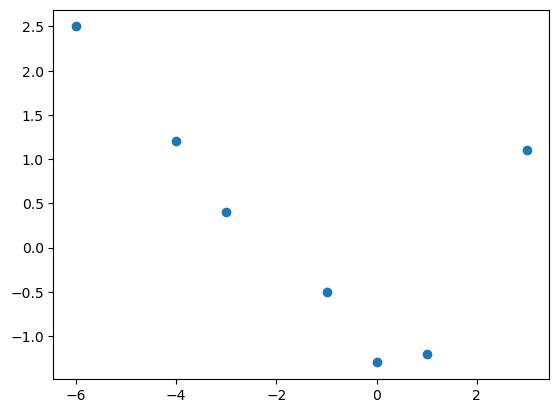

In [76]:
plt.scatter(X, Y)

In [77]:
XLIMS = -6.0, 3.0

## Теорія
Пошук найкращого наближення виконується в межах гільбертово простору з визначеним скінченним базисом та нормою.  

Дана функція задана таблично, при чому аргумент змінюється не дискретно. Розглядаємо лише методи для табличних функцій. Опускаємо апроксимацію дискретними поліномами чебишова.  

Я розглядатиму (лінійний) метод найменших квадратів з різними базисами.

Зверну увагу, що тут недоцільно апроксимувати тригонометричними функціями, бо ми не маємо періодичності

### Лінійний випадок
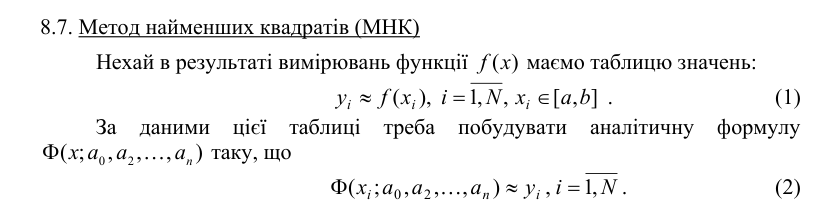
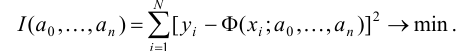
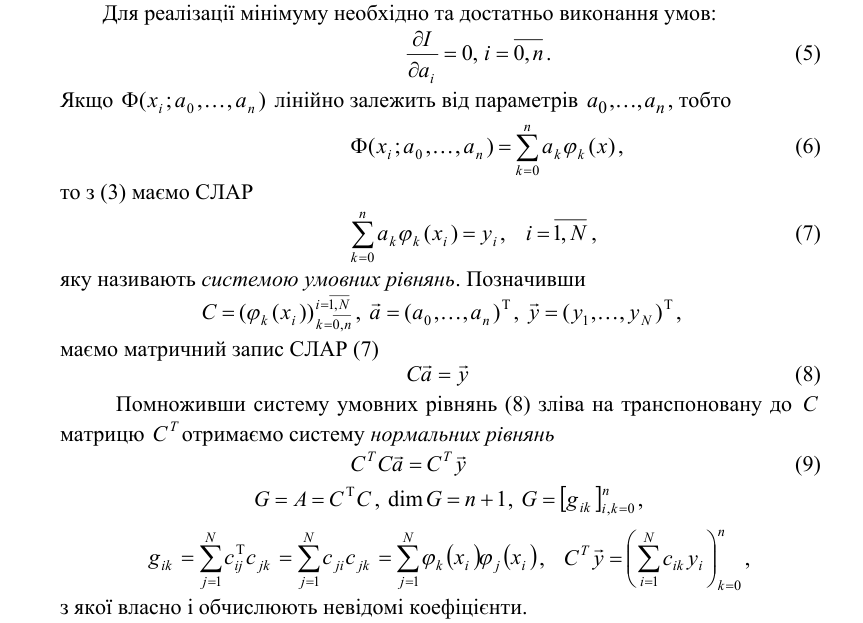


Тобто
$$a = (C^T C)^{-1}C^T y$$
для python з урахуванням що вектори будуть рядками маємо
$$a^T = y^T C (C^T C)^{-1}$$ 

### Нелінійний випадок

Параметри базових функцій, що нелінійно від них залежать, в основному обчислюється ітеративно, лінеаризуючи задачу на кожній ітерації. Виконується в деякому роді градієнтна процедура.  
Зверну увагу, що тут потрібне гарне початкове наближення.

Я не розглядатиму цей випадок

## 1. Апроксимація багаточленом

Розглядаємо базис $\phi_k = x^k, \quad k = \overline{0,n}$

Це лінійна задача найменших квадратів, бо $f(x; a_n) = \sum_{k=0}^n a_k x^k$ залежить від $a_k$ лінійно

In [78]:
# 1. polynomial
def prepare_poly_table(x, n):
    C = np.empty((n, x.shape[0]))
    C[0, :] = 1
    for i in range(1,n):
        C[i] = C[i-1] * x 
    return C

def apply_linear_params(w, Ct):
    return w @ Ct[:w.shape[0]]

def fit_poly(nparams):
    Ct = prepare_poly_table(X, nparams)
    w = Y @ Ct.T @ np.linalg.inv(Ct @ Ct.T)
    assert w.shape == (nparams,)
    rmse = np.linalg.norm(apply_linear_params(w, Ct) - Y) # root mean squared error
    return w, rmse 

def show_poly(w):
    form = ""
    for n,a in enumerate(w):
        if n > 0: form += ' + '
        form += f"{a:.3g} x^{n}"
    return form

RMSE for deg = 2  is  1.2497
RMSE for deg = 3  is  0.44871
RMSE for deg = 4  is  0.2893


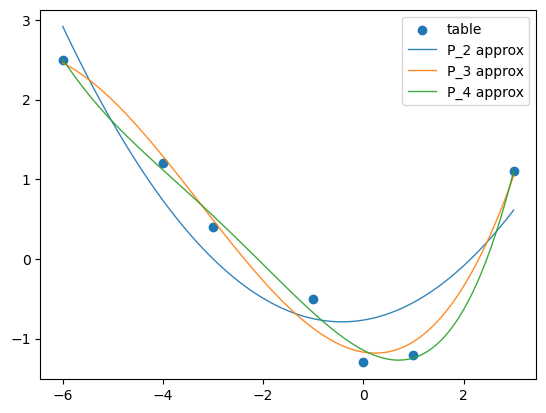

In [115]:
nparams = [3,4,5,6,7]
poly_fits = [fit_poly(n) for n in nparams]

# visualisation
max_nparams = np.max(nparams)
vizx = np.linspace(XLIMS[0], XLIMS[1], 100)
vizCt = prepare_poly_table(vizx, max_nparams)

plt.scatter(X, Y, label='table')
for n, (w, rmse) in zip(nparams[:3], poly_fits):
    print(f"RMSE for deg = {n-1}  is  {rmse:.5g}")
    plt.plot(vizx, apply_linear_params(w, vizCt), label=f'P_{n-1} approx', alpha=0.9, lw=1)
plt.legend()

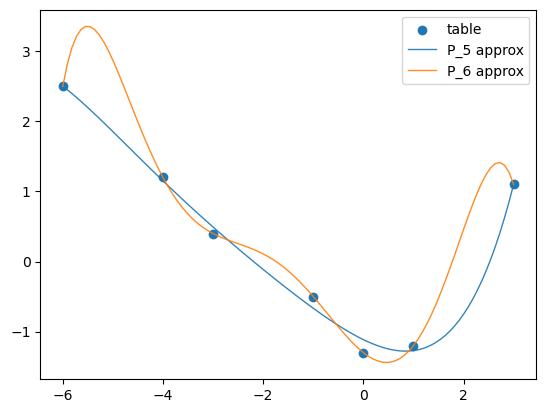

In [116]:
plt.scatter(X, Y, label='table')
plt.plot(vizx, apply_linear_params(poly_fits[3][0], vizCt), label=f'P_{nparams[3]-1} approx', alpha=0.9, lw=1)
plt.plot(vizx, apply_linear_params(poly_fits[4][0], vizCt), label=f'P_{nparams[4]-1} approx', alpha=0.9, lw=1)
plt.legend()

#### Результати

In [81]:
print("The best polynomial is")
print(show_poly(poly_fits[3][0]))

The best polynomial is
-1.11 x^0 + -0.347 x^1 + 0.137 x^2 + 0.0446 x^3 + 0.00839 x^4 + 0.000598 x^5


In [82]:
print("Another good polynomial is")
print(show_poly(poly_fits[2][0]))

Another good polynomial is
-1.15 x^0 + -0.33 x^1 + 0.182 x^2 + 0.0471 x^3 + 0.00409 x^4


Бачимо, що цілком доцільно представляти дану табличну функцію як поліном

## 2. Апроксимація експонентами

$\phi_k(x) = e^{kx}, \quad k=\overline{-n,n}$

Знову маємо лінійну задачу найменших квадратів

In [105]:
def calculate_exp(w, x):
    pows = np.arange(-n, n+1).reshape(-1,1)
    return w @ np.exp(pows * x)

def fit_exp(n):
    nparams = 2*n+1
    pows = np.arange(-n, n+1).reshape(-1,1)
    assert pows.shape == (nparams, 1)
    Ct = np.exp(pows * X)
    w = Y @ Ct.T @ np.linalg.inv(Ct @ Ct.T)
    assert w.shape == (nparams,)
    rmse = np.linalg.norm(apply_linear_params(w, Ct) - Y) # root mean squared error
    return w, rmse 

def show_exp(w):
    n = (w.shape[0] - 1) // 2
    k = -n
    form = ""
    for a in w:
        if k > -n:
            form += ' + '
        form += f"{a:.3g} exp({k}x)"
        k += 1
    return form

#### Результати

RMSE for 1-exponential fit is  1.9464
Formula is
> 0.00785 exp(-1x) + -0.467 exp(0x) + 0.0696 exp(1x)

RMSE for 2-exponential fit is  0.54042
Formula is
> -7.84e-05 exp(-2x) + 0.0393 exp(-1x) + -0.603 exp(0x) + -0.336 exp(1x) + 0.021 exp(2x)



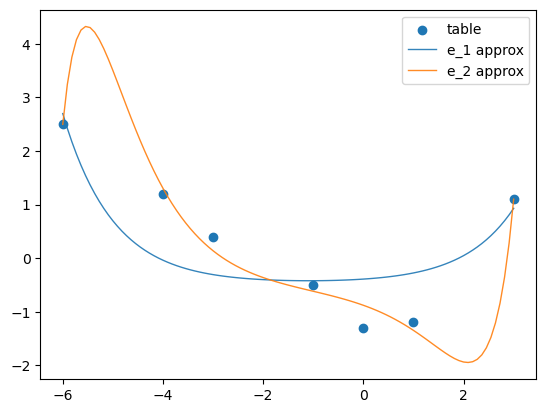

In [110]:
plt.scatter(X, Y, label='table')

n = 1
w, rmse = fit_exp(n)
vizx = np.linspace(XLIMS[0], XLIMS[1], 100)
print(f"RMSE for {n}-exponential fit is  {rmse:.5g}")
print("Formula is")
print("> "+ show_exp(w))
print()
plt.plot(vizx, calculate_exp(w, vizx), label=f'e_{n} approx', alpha=0.9, lw=1)


n = 2
w, rmse = fit_exp(n)
vizx = np.linspace(XLIMS[0], XLIMS[1], 100)
print(f"RMSE for {n}-exponential fit is  {rmse:.5g}")
print("Formula is")
print("> "+ show_exp(w))
print()
plt.plot(vizx, calculate_exp(w, vizx), label=f'e_{n} approx', alpha=0.9, lw=1)


plt.legend()

Бачимо, що експоненти підходять погано